In [16]:

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Загрузка данных
data = pd.read_csv('flight_delay.csv')

# Предварительный анализ данных
print(data.head())
print(data.info())
print(data.describe())


departureAirportColumn = data.columns[0]
destinationAirportColumn = data.columns[2]
scheduledDepartureTimeColumn = data.columns[1]
scheduledArrivalTimeColumn = data.columns[3]
delayColumn=data.columns[4]



  Depature Airport Scheduled depature time Destination Airport  \
0              SVO     2015-10-27 07:40:00                 HAV   
1              SVO     2015-10-27 09:50:00                 JFK   
2              SVO     2015-10-27 10:45:00                 MIA   
3              SVO     2015-10-27 12:30:00                 LAX   
4              OTP     2015-10-27 14:15:00                 SVO   

  Scheduled arrival time  Delay  
0    2015-10-27 20:45:00    0.0  
1    2015-10-27 20:35:00    2.0  
2    2015-10-27 23:35:00    0.0  
3    2015-10-28 01:20:00    0.0  
4    2015-10-27 16:40:00    9.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Depature Airport         675513 non-null  object 
 1   Scheduled depature time  675513 non-null  object 
 2   Destination Airport      675513 non-null  object 
 3   Scheduled

In [23]:
# Обработка строковых данных
le = LabelEncoder()
data[departureAirportColumn] = le.fit_transform(data[departureAirportColumn])
data[destinationAirportColumn] = le.fit_transform(data[destinationAirportColumn])

# Преобразование временных меток в datetime
data[scheduledDepartureTimeColumn] = pd.to_datetime(data[scheduledDepartureTimeColumn])
data[scheduledArrivalTimeColumn] = pd.to_datetime(data[scheduledArrivalTimeColumn])

# Извлечение признаков из временных меток
data['Year'] = data[scheduledDepartureTimeColumn].dt.year
data['Month'] = data[scheduledDepartureTimeColumn].dt.month
data['Day'] = data[scheduledDepartureTimeColumn].dt.day
data['Day of week'] = data[scheduledDepartureTimeColumn].dt.dayofweek

print(data.columns)

Index(['Depature Airport', 'Scheduled depature time', 'Destination Airport',
       'Scheduled arrival time', 'Delay', 'Year', 'Month', 'Day',
       'Day of week', 'Flight duration'],
      dtype='object')


In [25]:
# Рассчет продолжительности полета
data['Flight duration'] = (data[scheduledArrivalTimeColumn] - data[scheduledDepartureTimeColumn]).dt.total_seconds() / 60

# Разделение данных на обучающую и тестовую выборки
train_data = data[data['Year'] < 2018]
test_data = data[data['Year'] == 2018]

X_train = train_data[[departureAirportColumn, destinationAirportColumn, 'Month', 'Day', 'Day of week', 'Flight duration']]
y_train = train_data['Delay']
X_test = test_data[[departureAirportColumn, destinationAirportColumn, 'Month', 'Day', 'Day of week', 'Flight duration']]
y_test = test_data['Delay']

# Обнаружение и удаление выбросов (используем межквартильный размах на одном месяце)
month_data = data[data['Month'] == 1]  # пример для января
q1 = month_data['Delay'].quantile(0.25)
q3 = month_data['Delay'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data = data[(data['Delay'] >= lower_bound) & (data['Delay'] <= upper_bound)]

# Обучение моделей машинного обучения
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor()
}


In [26]:
# Оценка моделей и сравнение их результатов
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    results[name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train R2': train_r2,
        'Test R2': test_r2
    }
    print(f"{name} - Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}, Train R2: {train_r2:.2f}, Test R2: {test_r2:.2f}")

# Сравнение моделей
results_df = pd.DataFrame(results).T
print(results_df)

Linear Regression - Train MSE: 2148.70, Test MSE: 1615.50, Train R2: 0.00, Test R2: -0.01
Ridge Regression - Train MSE: 2148.70, Test MSE: 1615.50, Train R2: 0.00, Test R2: -0.01
Random Forest - Train MSE: 740.56, Test MSE: 2339.18, Train R2: 0.66, Test R2: -0.46
                     Train MSE     Test MSE  Train R2   Test R2
Linear Regression  2148.698470  1615.503770  0.003364 -0.007944
Ridge Regression   2148.698470  1615.503771  0.003364 -0.007944
Random Forest       740.556647  2339.180683  0.656506 -0.459460


C:\Users\twent\AppData\Local\Temp\ipykernel_509428\3159783843.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='Test R2', palette='viridis')


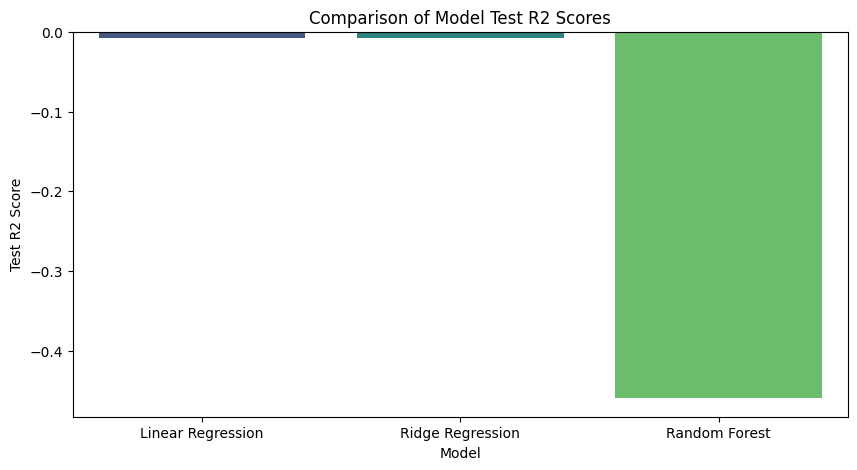

In [27]:
# Визуализация результатов
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.reset_index(), x='index', y='Test R2', palette='viridis')
plt.title('Comparison of Model Test R2 Scores')
plt.xlabel('Model')
plt.ylabel('Test R2 Score')
plt.show()